[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mitchell-Mirano/Allison/blob/develop/examples/nn/3-Iris_dataset.ipynb)

In [ ]:
!pip install git+https://github.com/Mitchell-Mirano/Allison.git@develop

zsh:1: command not found: pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Union

import allison
from allison.datasets import train_test_split
from allison.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from allison.nn import NeuralNetwork
from allison import tensor
from allison.nn import CrossEntropyLoss
from allison.metrics import accuracy
from allison.optim import RMSprop
from allison.nn import Linear,Relu

In [3]:
device = "gpu" if allison.cuda.is_available() else "cpu"
device

Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA runtime version: 13000
CuPy version: 13.6.0


'gpu'

In [4]:
df  = pd.read_csv("../data/Iris.csv")
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
labels = df["Species"].unique()

labels2id = {label: i for i, label in enumerate(labels)}
id2labels = {i: label for i, label in enumerate(labels)}

In [6]:
df['labels'] = df['Species'].map(labels2id)
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,labels
0,1,5.1,3.5,1.4,0.2,Iris-setosa,0
1,2,4.9,3.0,1.4,0.2,Iris-setosa,0
2,3,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5,5.0,3.6,1.4,0.2,Iris-setosa,0


In [7]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
features = ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]
labels = ["labels"]

X_train = df_train[features]
y_train = df_train[labels]

X_test = df_test[features]
y_test = df_test[labels]

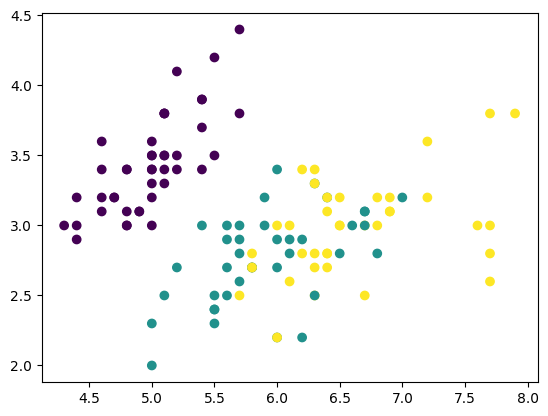

In [9]:
plt.scatter(X_train['SepalLengthCm'], X_train['SepalWidthCm'], c=y_train['labels'])

In [10]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
X_train_scaled.shape, y_train.shape, X_test_scaled.shape, y_test.shape

((120, 4), (120, 1), (30, 4), (30, 1))

In [12]:
if device == "gpu":
    X_train_tensor = tensor(X_train_scaled).to(device)
    Y_train_tensor = tensor(y_train).to(device)

    X_test_tensor = tensor(X_test_scaled).to(device)
    Y_test_tensor = tensor(y_test).to(device)
else: 
    X_train_tensor = tensor(X_train_scaled)
    Y_train_tensor = tensor(y_train)

    X_test_tensor = tensor(X_test_scaled)
    Y_test_tensor=  tensor(y_test)


print(X_train_scaled.shape,  Y_train_tensor.shape, X_test_scaled.shape,   Y_test_tensor.shape)
print(X_train_tensor.device, Y_train_tensor.device, X_test_tensor.device, Y_test_tensor.device)

(120, 4) (120, 1) (30, 4) (30, 1)
gpu gpu gpu gpu


In [13]:
class Net(NeuralNetwork):

    def __init__(self):
        super().__init__()
        self.fc1 = Linear(4, 8)
        self.fc2 = Linear(8, 4)
        self.fc3 = Linear(4, 3)
        self.relu = Relu()

    def forward(self, x: tensor) -> tensor:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    

if device == "gpu":
    net = Net().to(device)
else:
    net = Net()
criterion = CrossEntropyLoss()
optimizer = RMSprop(net.parameters(), lr=1e-2)


In [14]:
logits = net(X_train_tensor)

In [15]:
# Bucle de entrenamiento mejorado
for epoch in range(1000 + 1):
    logits = net(X_train_tensor)
    loss = criterion(logits, Y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        preds = allison.argmax(logits, axis=1, keepdims=True)
        acc_train = (preds.data== Y_train_tensor.data).mean()
        with allison.no_grad():
            logits = net(X_test_tensor)
            preds = allison.argmax(logits, axis=1, keepdims=True)
            acc_test = (preds.data == Y_test_tensor.data).mean()

        # Usamos una f-string para formatear y alinear la salida
        print(f"[{device}] Epoch {epoch:5d} | Loss: {loss.data:.4f} | Acc Train: {acc_train*100:.2f}% | Acc Test: {acc_test*100:.2f}%")

        if acc_test >= 0.98:  # Mejoramos el criterio de parada
            print(f"Entrenamiento completado en {epoch} epochs!")
            break


[gpu] Epoch     0 | Loss: 1.3640 | Acc Train: 34.17% | Acc Test: 50.00%
[gpu] Epoch    10 | Loss: 0.4880 | Acc Train: 85.83% | Acc Test: 93.33%
[gpu] Epoch    20 | Loss: 0.2957 | Acc Train: 90.83% | Acc Test: 93.33%
[gpu] Epoch    30 | Loss: 0.1825 | Acc Train: 94.17% | Acc Test: 100.00%
Entrenamiento completado en 30 epochs!
